### Make sure you have installed the libraries below in your virtual environment

In [1]:
from typing import *
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from gs_quant.timeseries import returns, diff


warnings.filterwarnings('ignore')

In [2]:
#DATA CLEANERS

class BaseCleaner():
    
    @classmethod
    def _post_clean(cls, df):
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df = df[::-1]
        return df

#CDS Cleaning
class CDSCleaner(BaseCleaner):
    DEFAULT_START_DATE = '1/1/2018'
    
    @classmethod
    def _clean(cls, df):
        df.rename(columns={'Date': 'date', 'Last Price':'price'}, inplace=True)
        return cls._post_clean(df)

#EWZ IV Cleaning
class VolCleaner(BaseCleaner):
    
    @classmethod
    def _clean(cls, df):
        df.rename(columns={'Date': 'date', 'Last Value':'price'}, inplace=True)
        df = df.apply(lambda x: x.str.strip()).replace(' ', np.nan)
        df['price'] = pd.to_numeric(df['price'])
        df.dropna(inplace=True)
        return cls._post_clean(df)
        
#SPX Cleaning
class SPXCleaner(BaseCleaner):
    
    @classmethod
    def _clean(cls, df):
        df.rename(columns={'Date': 'date', 'Last Price':'price'}, inplace=True)
        df.drop(columns=['Volume', 'SMAVG (15)'], inplace=True)
        return cls._post_clean(df)


#OIL Cleaning
class USOILCleaner(BaseCleaner):
    
    @classmethod
    def _clean(cls, df):
        df.rename(columns={'Date': 'date', 'Last Price':'price'}, inplace=True)
        df.drop(columns=['Open Interest'], inplace=True)
        return cls._post_clean(df)
    
#XLE Cleaning
class ETFCleaner(BaseCleaner):
    
    @classmethod
    def _clean(cls, df):
        df.rename(columns={'Date': 'date', 'Last Price':'price'}, inplace=True)
        return cls._post_clean(df)

Note that the datasets should be in a folder called options/em_vol/

In [3]:
from typing import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

class DatasetHandler():
    ROOT_DIRECTORY = "options/em_vol/"
    
    def _load_dataset(self, file_name:str):
        temp_df = pd.read_csv(self.ROOT_DIRECTORY + f"{file_name}")
        setattr(self, file_name.split('.')[0], temp_df)   

In [4]:
DATASETS = [
    'cds2y.csv',
    'cds5y.csv',
    'cds10y.csv',
    'spx10y.csv',
    'ewz.csv',
    'ewz1mIV.csv',
    'ewz3mIV.csv',
    'ewz1mHV.csv',
    'ewz3mHV.csv',
    'xle.csv',
    'usoil.csv',
    'pnl.csv'
]

dataset_handler = DatasetHandler()
for dataset in DATASETS: dataset_handler._load_dataset(dataset)
#CDS
dataset_handler.cds2y = CDSCleaner._clean(dataset_handler.cds2y)
dataset_handler.cds5y = CDSCleaner._clean(dataset_handler.cds5y)
dataset_handler.cds10y = CDSCleaner._clean(dataset_handler.cds10y)
#VOL
dataset_handler.ewz1mIV = VolCleaner._clean(dataset_handler.ewz1mIV)
dataset_handler.ewz3mIV = VolCleaner._clean(dataset_handler.ewz3mIV)
dataset_handler.ewz1mHV = VolCleaner._clean(dataset_handler.ewz1mHV)
dataset_handler.ewz3mHV = VolCleaner._clean(dataset_handler.ewz3mHV)
#SPX
dataset_handler.spx10y = SPXCleaner._clean(dataset_handler.spx10y)
dataset_handler.usoil = USOILCleaner._clean(dataset_handler.usoil)
#ETFs
dataset_handler.xle = ETFCleaner._clean(dataset_handler.xle)
dataset_handler.ewz = ETFCleaner._clean(dataset_handler.ewz)

In [5]:
class VolHelper():
    
    @classmethod
    def compute_realized_vol(cls, df, days=21):
        df['log_rtn'] = np.log(df['price']).diff()
        # Classical (returns are demeaned, dof=1)
        df['real_var'] = df['log_rtn'].rolling(days).var() * 252
        df['real_vol'] = np.sqrt(df['real_var']) * 100
        return df
    
    def standardize_realized_vol(cls, vol_series):
        pass

In [6]:
dataset_handler.ewz = VolHelper.compute_realized_vol(dataset_handler.ewz, days=30)

#### A comparison of my own calculation of realized volatility vs Bloomberg's

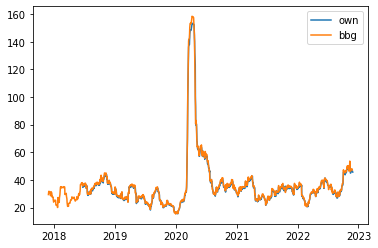

In [7]:
plt.plot(dataset_handler.ewz['real_vol'], label='own')
plt.plot(dataset_handler.ewz1mHV, label = 'bbg')
plt.legend()

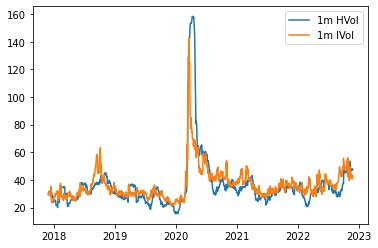

In [8]:
plt.plot(dataset_handler.ewz1mHV, label='1m HVol')
plt.plot(dataset_handler.ewz1mIV, label='1m IVol')
plt.legend()

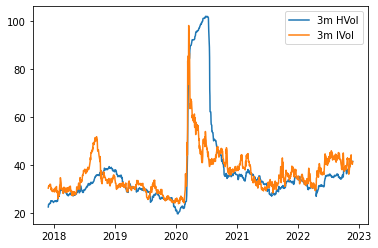

In [9]:
plt.plot(dataset_handler.ewz3mHV, label='3m HVol')
plt.plot(dataset_handler.ewz3mIV, label='3m IVol')
plt.legend()

<AxesSubplot:ylabel='Frequency'>

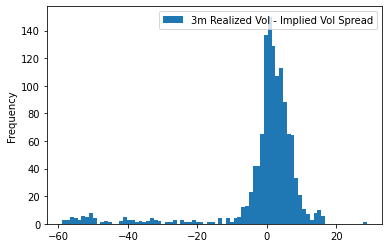

In [10]:
spread = (dataset_handler.ewz3mIV - dataset_handler.ewz3mHV)
spread = spread.rename(columns={'price': '3m Realized Vol - Implied Vol Spread'})
spread.plot.hist(bins=80)

<AxesSubplot:ylabel='Frequency'>

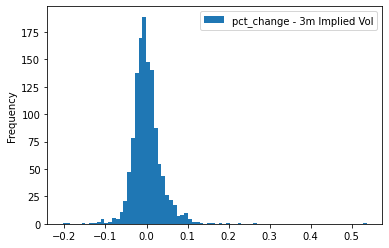

In [11]:
new = dataset_handler.ewz3mIV.pct_change()
new = new.rename(columns={'price': 'pct_change - 3m Implied Vol'})
new.plot.hist(bins=80)

<AxesSubplot:xlabel='date'>

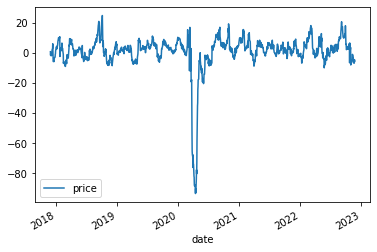

In [12]:
(dataset_handler.ewz1mIV - dataset_handler.ewz1mHV).plot()

In [13]:

class EMVolAnalyzer():
    
    def _merge_data(self, datahandler, start_from, end_at):
        #using dates with available data for vol as reference index
        reference_index = datahandler.ewz1mIV.loc[start_from:end_at].index
        self.df = pd.DataFrame()
        self.df['cds2y'] = datahandler.cds2y.loc[datahandler.cds2y.index.isin(reference_index)]['price']
        self.df['cds5y'] = datahandler.cds5y.loc[datahandler.cds5y.index.isin(reference_index)]['price']
        self.df['ewz1m_impvol'] = datahandler.ewz1mIV.loc[datahandler.ewz1mIV.index.isin(reference_index)]['price']
        self.df['ewz3m_impvol'] = datahandler.ewz3mIV.loc[datahandler.ewz3mIV.index.isin(reference_index)]['price']
        self.df['cds5y'] = datahandler.cds5y.loc[datahandler.cds5y.index.isin(reference_index)]['price']
        self.df['spx'] = datahandler.spx10y.loc[datahandler.spx10y.index.isin(reference_index)]['price']
        self.df['ewz'] = datahandler.ewz.loc[datahandler.ewz.index.isin(reference_index)]['price']
        self.df['xle']= datahandler.xle.loc[datahandler.xle.index.isin(reference_index)]['price']
        
    def run_pca(self, components, period):
        f_loadings = defaultdict(list)
        for start in range(len(self.df) - period):
            d = self.df.iloc[start:start + period]
            d = (d - d.mean()) / d.std()
            model = PCA(n_components=components)
            model.fit(d)
            for i, c in enumerate(model.explained_variance_ratio_): f_loadings[i].append(c)
        factors = pd.DataFrame(f_loadings)
        factors.index = self.df.index[period:]
        plt.figure(figsize=(12, 8))
        plt.stackplot(factors.index, factors.transpose())
        plt.title('Contribution to variance from each component')
        return factors

In [14]:
volAnalysis = EMVolAnalyzer()
volAnalysis._merge_data(dataset_handler, '2018-09-10', '2022-10-27')

In [15]:
frame_t = volAnalysis.df.copy().apply(lambda x: returns(x))
frame_t.dropna(inplace=True)
frame_t.drop(columns=['ewz'])
components = 2
period = 100

Text(0.5, 1.0, 'Contribution to variance from each component')

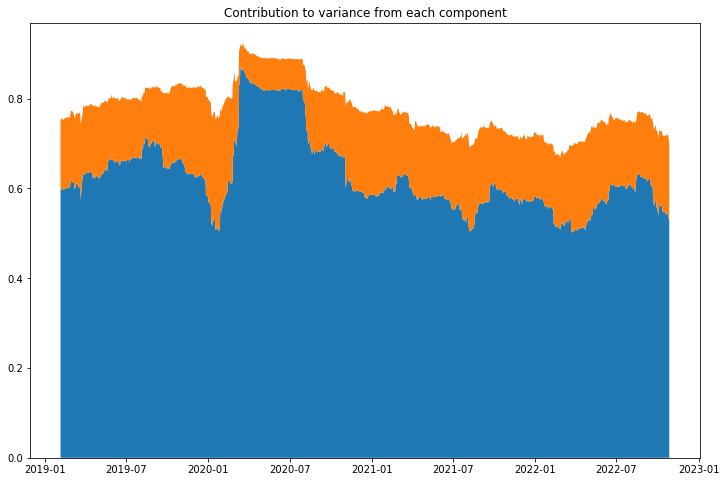

In [16]:
f_loadings = defaultdict(list)
for start in range(len(frame_t) - period):
    d = frame_t.iloc[start:start + period]
    d = (d - d.mean()) / d.std()
    model = PCA(n_components=components)
    model.fit(d)
    for i, c in enumerate(model.explained_variance_ratio_): f_loadings[i].append(c)

factors = pd.DataFrame(f_loadings)
factors.index = frame_t.index[period:]
plt.figure(figsize=(12, 8))
plt.stackplot(factors.index, factors.transpose())
plt.title('Contribution to variance from each component')

In [17]:
full_model = PCA(n_components=3)
full_data = (frame_t - frame_t.mean()) / frame_t.std()
full_model.fit(full_data)
components_full = pd.DataFrame(full_model.components_, columns=frame_t.columns)

In [29]:
volAnalysis.df.columns

Index(['cds2y', 'cds5y', 'ewz1m_impvol', 'ewz3m_impvol', 'spx', 'ewz', 'xle'], dtype='object')

In [154]:
# color_map = {
#     'Equities': '#20396D',
#     'FX': '#68A2BF',
#     'Rates': '#CD252B',
#     'Commodities': '#E3E311',
#     'Credit': '#E3E000',
#     'Vol': '#67E311',
#     'Fundamental': '#25cdae',
# }

# asset_map = {
#     'ewz': 'Equities',
#     'xle': 'Equities',
#     'spx': 'Equities',
#     'cds2y':'Credit',
#     'cds5y':'Credit',
#     'ewz1m_impvol': 'Equities',
#     'ewz3m_impvol': 'Equities'
# }

# fig = plt.figure(figsize=(16, 16))
# comp1, comp2 = 0, 1
# for i, row in components_full.iteritems():
#     plt.scatter(row[comp1], row[comp2], color=color_map[asset_map[row.name]], label=row.name)
#     plt.text(row[comp1]-0.02, row[comp2]-.01, row.name, fontsize=9)

# plt.axhline(0, color='grey')
# plt.axvline(0, color='grey')
# plt.title('PC1 vs PC2 - Full History')
# plt.xlabel('PC'+str(comp1+1))
# plt.ylabel('PC'+str(comp2+1))

In [18]:
pca_returns = pd.DataFrame(full_model.transform(full_data), index=full_data.index)
res = pca_returns.dot(components_full) * frame_t.std() + frame_t.mean()

In [19]:

def transform(tr_df, since):
    t_d = tr_df.copy()[since:]
    for key, v in t_d.items():
        t_d[key] = t_d[key].cumsum()
    return t_d

def compare_plot(asset, actual, predicted, realized):
    plt.figure(figsize=(10, 4))
    plt.plot(actual[asset], label='actual')
    plt.plot(predicted[asset], label='predicted')
    plt.plot(realized, label='realized')
    plt.title(f"PCA-Predicted {asset} timeseries")
    plt.legend()
    plt.show()

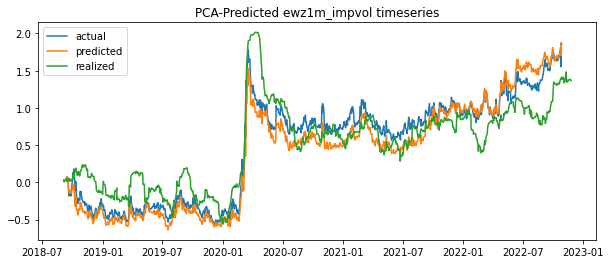

In [20]:
# compare each of the variables since beginning of the year
since = '2018-09-01'
predicted = transform(res, since)
actual = transform(frame_t, since)
ewz1mHV_returns = dataset_handler.ewz1mHV.copy().apply(lambda x: returns(x))
ewz1mHV_returns.dropna(inplace=True)
ewz1mHV_ = transform(ewz1mHV_returns, since)

fx_graphs = ['ewz1m_impvol']
for asset in fx_graphs: compare_plot(asset, actual, predicted, ewz1mHV_)

### Note the strong divergence in realized vs predicted vs actual after 2022-07, during the presidential election cycle

<AxesSubplot:ylabel='Frequency'>

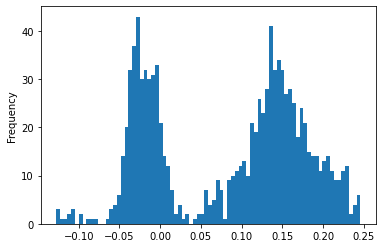

In [21]:
forecast_spread = actual['ewz3m_impvol'] - predicted['ewz3m_impvol']
#forecast_spread = forecast_spread.rename(columns={'price': '3m Actual IVol - 3m Forecasted IVol'})
forecast_spread.plot.hist(bins=80)
#forecast_spread.plot()

### Runoff presidential election in Brazil is in early October, 2018. You could easily have anticipated this downwards trend on the spread and traded the Skew

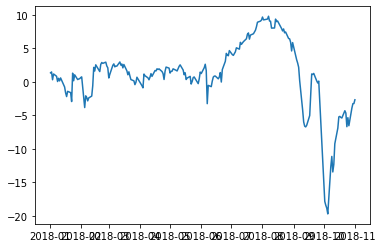

In [24]:
plt.plot(dataset_handler.ewz3mIV.loc['2018-01-01':'2018-11-01'] - dataset_handler.ewz1mIV.loc['2018-01-01':'2018-11-21'], label='3m-1m ATM spread 2022')


### Same phenomenon occured in 2022!

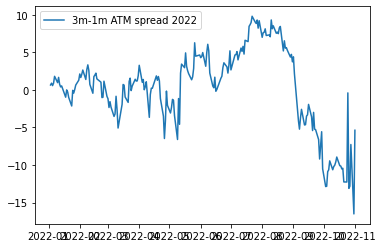

In [27]:
plt.plot(dataset_handler.ewz3mIV.loc['2022-01-01':'2022-11-01'] - dataset_handler.ewz1mIV.loc['2022-01-01':'2022-11-21'], label='3m-1m ATM spread 2022')
plt.legend()

### And also in 2014! try proving this yourself